In [1]:
from skimage import measure
import numpy as np
import pandas as pd
from PIL import Image
import json
import re
import glob
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path

In [15]:
def calculate_segmentation(mask_path):
    """Calcula la segmentación como una lista de puntos a partir de una máscara binaria."""
    mask = Image.open(mask_path).convert("L")
    mask_array = np.array(mask)
    contours, _ = cv2.findContours(mask_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = [contour.ravel().tolist() for contour in contours if len(contour) >= 3]
    return segmentation

def calculate_bbox(mask_array):
    """Calcula el bounding box (bbox) de una máscara binaria."""
    coords = np.argwhere(mask_array > 0)
    top_left = coords.min(axis=0)
    bottom_right = coords.max(axis=0)
    bbox = [top_left[1], top_left[0], bottom_right[1] - top_left[1], bottom_right[0] - top_left[0]]
    return bbox

def generate_image_entry(image_id, dataset_id, file_name, width, height):
    """Genera la entrada para la sección 'images' del formato COCO."""
    return {
        "id": int(image_id),
        "Dataset_ID": dataset_id,
        "file_name": file_name,
        "width": int(width),
        "height": int(height)
    }

def generate_annotation_entry(annotation_id, image_id, category_id, bbox, segmentation, tipoTumor):
    """Genera la entrada para la sección 'annotations' del formato COCO."""
    return {
        "id": int(annotation_id),
        "image_id": int(image_id),
        "category_id": int(category_id),
        "bbox": [int(coord) for coord in bbox],
        "segmentation": segmentation,
        "type": tipoTumor,
        "area": float(bbox[2] * bbox[3])  # Ancho * Alto
    }

def process_files_to_coco(png_files, coco_dir):
    """Procesa los archivos PNG y genera el archivo COCO JSON."""
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": []
    }
    image_id = 0
    annotation_id = 0
    category_map = {}

    # Cargar los CSV
    csv_png_mass_test = pd.read_csv(r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\nuevo_df_mass_test_png.csv")
    csv_png_mass_train = pd.read_csv(r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\nuevo_df_mass_train_png.csv")
    csv_png_calc_test = pd.read_csv(r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\nuevo_df_calc_test_png.csv")
    csv_png_calc_train = pd.read_csv(r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\nuevo_df_calc_train_png.csv")

    for png_path in png_files:
        if "ROI" not in png_path:
            continue

        if "Calc-Test" in png_path:
            tipoTumor = "calc"
            df = csv_png_calc_test
        elif "Calc-Training" in png_path:
            tipoTumor = "calc"
            df = csv_png_calc_train
        elif "Mass-Test" in png_path:
            tipoTumor = "mass"
            df = csv_png_mass_test
        elif "Mass-Training" in png_path:
            tipoTumor = "mass"
            df = csv_png_mass_train
        else:
            continue

        # Extraer el dataset_id y la patología
        dataset_id_match = re.search(r"P_\d+", png_path)
        if not dataset_id_match:
            continue
        dataset_id = dataset_id_match.group(0)

        pathology_row = df[df["patient_id"] == dataset_id]
        if pathology_row.empty:
            continue

        pathology = pathology_row["pathology"].iloc[0]
        supercategory = f"{tipoTumor}_{pathology}"

        # Agregar la categoría si no existe
        if supercategory not in category_map:
            category_id = len(category_map) + 1
            category_map[supercategory] = category_id
            coco_data["categories"].append({
                "id": category_id,
                "name": "ROI",
                "supercategory": supercategory
            })
        else:
            category_id = category_map[supercategory]

        # Obtener el nombre del archivo
        file_name_match = re.search(r"CBIS-DDSM.*", png_path)
        if not file_name_match:
            continue
        file_name_includePath = file_name_match.group(0)

        # Cargar la imagen y máscara
        with Image.open(png_path) as img:
            width, height = img.size

        mask = Image.open(png_path).convert("L")
        mask_array = np.array(mask)

        # Calcular bbox y segmentación
        bbox = calculate_bbox(mask_array)
        segmentation = calculate_segmentation(png_path)

        # Generar entradas para COCO
        coco_data["images"].append(
            generate_image_entry(image_id, dataset_id, file_name_includePath, width, height)
        )
        coco_data["annotations"].append(
            generate_annotation_entry(annotation_id, image_id, category_id, bbox, segmentation, tipoTumor)
        )

        # Incrementar IDs
        image_id += 1
        annotation_id += 1

    # Guardar el archivo JSON
    coco_json_path = os.path.join(coco_dir, "annotations.json")
    with open(coco_json_path, "w") as json_file:
        json.dump(coco_data, json_file, indent=4)

# Ruta donde están los archivos DICOM
png_dir = r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\CBIS-DDSM"
png_files = glob.glob(os.path.join(png_dir, "**/*.png"), recursive=True)

# Directorio para almacenar los archivos en formato COCO
coco_dir = r"D:\Archivos_DICOM_COCO\manifest-ZkhPvrLo5216730872708713142"
os.makedirs(coco_dir, exist_ok=True)

# Procesar archivos
process_files_to_coco(png_files, coco_dir)


In [1]:
# dibujo

In [3]:
def find_full_path_for_roi(png_files, roi_path, user_id):
    for im_path in png_files:
        if "full" in im_path and user_id in im_path:
            return im_path
    return None

# Función para trazar una imagen con bounding boxes y segmentaciones
def plot_image(image, annotations, save_path=None):
    """Visualiza las segmentaciones y bounding boxes en una imagen."""
    image = np.array(image)
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image, cmap="gray")

    img_height, img_width = image.shape[:2]

    # Dibujar los bounding boxes y segmentaciones
    for annotation in annotations:
        # Bounding box
        x, y, w, h = annotation['bbox']
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Segmentación
        for segmentation in annotation['segmentation']:
            # Ajustar las coordenadas de segmentación al tamaño de la imagen
            x_coords = [segmentation[i] for i in range(0, len(segmentation), 2)]
            y_coords = [segmentation[i] for i in range(1, len(segmentation), 2)]

            # Verificar si las coordenadas están normalizadas (entre 0 y 1)
            if max(x_coords) <= 1.0 and max(y_coords) <= 1.0:
                x_coords = [x * img_width for x in x_coords]
                y_coords = [y * img_height for y in y_coords]

            # Dibujar el polígono de segmentación
            ax.plot(x_coords + [x_coords[0]], y_coords + [y_coords[0]], linewidth=1, color='r')

    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
    else:
        plt.show()

        
# Directorio principal de las imágenes procesadas
input_dir = r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142"
output_dir = r"D:\Archivos_DICOM_PNG_Reduced_Plotted"

# Crear el directorio de salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Ruta del archivo COCO JSON generado anteriormente
coco_json_path = r"D:\Archivos_DICOM_COCO\manifest-ZkhPvrLo5216730872708713142\annotations.json"

png_dir = r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\CBIS-DDSM"
png_files = glob.glob(os.path.join(png_dir, "**/*.png"), recursive=True)

# Cargar el archivo COCO JSON
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

# Crear un diccionario de anotaciones por ID de imagen
annotations_by_image_id = {}
for annotation in coco_data['annotations']:
    image_id = annotation['image_id']
    if image_id not in annotations_by_image_id:
        annotations_by_image_id[image_id] = []
    annotations_by_image_id[image_id].append(annotation)

# Procesar las imágenes del COCO JSON
for image_info in coco_data['images']:
    image_id = image_info['id']
    dataset_id = image_info['Dataset_ID']
    file_name = image_info['file_name']
    annotations = annotations_by_image_id.get(image_id, [])
    
    # Rutas de entrada y salida
    input_image_path = os.path.join(input_dir, file_name)
    output_image_path = os.path.join(output_dir, file_name)
    
    dataset_id = re.search(r"P_\d+", input_image_path).group(0)
    # Crear subdirectorios en el directorio de salida si es necesario
    os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
    
    full_image_correspondent = find_full_path_for_roi(png_files, input_image_path, dataset_id)
    if full_image_correspondent == None:
        continue
#     print(full_image_correspondent)
#     print(input_image_path)
    
    # Cargar la imagen y trazar
    if os.path.exists(input_image_path):
        with Image.open(full_image_correspondent) as img:
            plot_image(img, annotations, save_path=output_image_path)

print("Generación de imágenes con segmentaciones completada.")

Generación de imágenes con segmentaciones completada.


#### TODO
 *OK* - Superactegory
 
 *OK* - 4 categorias posibles: calc_benign , calc_malign, mass_benign, mass_malign
 
 *OK* - Paciente en un solo set y separar con la densitat
 
 *OK* - Split Train Test/Val - cada set tiene ID unicos (3 JSONS) ==> misma distribucion de breast density en cada set
 
 - En la tesis justificar porque lo hacemos para la densidad
 - modificar mmdetection tutorial para nuestros datos de CBIS-DDSM

In [ ]:
# Separar data entre [train, test, val]
# Tener en cuenta que hay que separar por:
#    - densidad
#    - un paciente solo puede estar en un set, no puede estar repetido


In [10]:
png_dir = r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\CBIS-DDSM"
png_files = glob.glob(os.path.join(png_dir, "**/*.png"), recursive=True)

csv_png_mass_test=pd.read_csv(r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\nuevo_df_mass_test_png.csv")
csv_png_mass_train=pd.read_csv(r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\nuevo_df_mass_train_png.csv")
csv_png_calc_test=pd.read_csv(r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\nuevo_df_calc_test_png.csv")
csv_png_calc_train=pd.read_csv(r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\nuevo_df_calc_train_png.csv")

In [7]:
for png_path in png_files:
    df = None
    m_type = None
    if "Calc-Test" in png_path:
        m_type = "calc"
        df = nuevo_df_calc_test
        nuevo_df = csv_png_mass_train
    elif "Calc-Training" in png_path:
        m_type = "calc"
        df = df_calc_train
        nuevo_df = csv_png_calc_train
    elif "Mass-Test" in png_path:
        m_type = "mass"
        df = csv_png_mass_test
        nuevo_df = csv_png_mass_test
    elif "Mass-Training" in png_path:
        m_type = "mass"
        df = df_mass_train
        nuevo_df = csv_png_calc_test
    
    
    dataset_id = re.search(r"P_\d+", png_path).group(0)
    pathology = df[df["patient_id"] == dataset_id]["pathology"].head(1).iloc[0]
    supercategory = m_type+"_"+pathology
    print(supercategory)
    break

mass_BENIGN


In [60]:
import os
import re
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

# Directorio base de las imágenes PNG
png_dir = r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\CBIS-DDSM"
png_files = glob.glob(os.path.join(png_dir, "**/*.png"), recursive=True)

# Cargar datos de los CSVs
csv_png_mass_test = pd.read_csv(r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\nuevo_df_mass_test_png.csv")
csv_png_mass_train = pd.read_csv(r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\nuevo_df_mass_train_png.csv")
csv_png_calc_test = pd.read_csv(r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\nuevo_df_calc_test_png.csv")
csv_png_calc_train = pd.read_csv(r"D:\Archivos_DICOM_PNG_Reduced\manifest-ZkhPvrLo5216730872708713142\nuevo_df_calc_train_png.csv")

# Crear un DataFrame temporal con las rutas y extraer patient_id de las rutas de los archivos
png_data = pd.DataFrame({
    "file_path": png_files,
    "patient_id": [re.search(r"P_\d+", path).group(0) for path in png_files]
})

# Unir todos los datasets de los CSVs en uno solo
all_data = pd.concat([
    csv_png_mass_test,
    csv_png_mass_train,
    csv_png_calc_test,
    csv_png_calc_train
], ignore_index=True)

# Combinar las rutas con los datos del CSV usando patient_id
all_data = all_data.merge(png_data, on="patient_id", how="left")

# Agrupar por paciente
grouped = all_data.groupby("patient_id").agg({
    "breast_density": "mean",  # Promedio de la densidad
    "file_path": list  # Lista de archivos por paciente
}).reset_index()

mode_density = grouped["breast_density"].mode()[0]
grouped["breast_density"].fillna(mode_density, inplace=True)

# Verificar la distribución de densidades
densities = grouped["breast_density"].value_counts(normalize=True).sort_index()
print("Distribución inicial de densidades:\n", densities)

# Dividir en conjuntos train, val, test
train, temp = train_test_split(grouped, test_size=0.4, stratify=grouped["breast_density"], random_state=42)
val, test = train_test_split(temp, test_size=0.5, stratify=temp["breast_density"], random_state=42)

# Validar la distribución de densidades en los conjuntos
print("Densidad Train:\n", train["breast_density"].value_counts(normalize=True).sort_index())
print("Densidad Val:\n", val["breast_density"].value_counts(normalize=True).sort_index())
print("Densidad Test:\n", test["breast_density"].value_counts(normalize=True).sort_index())

# Crear listas de archivos para cada conjunto, eliminando valores no válidos
train_files = train.explode("file_path")["file_path"].dropna().astype(str).tolist()
val_files = val.explode("file_path")["file_path"].dropna().astype(str).tolist()
test_files = test.explode("file_path")["file_path"].dropna().astype(str).tolist()

# Guardar los resultados en archivos
output_dir = r"D:\prueba_split"
os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(output_dir, "train_files.txt"), "w") as f:
    f.write("\n".join(train_files))

with open(os.path.join(output_dir, "val_files.txt"), "w") as f:
    f.write("\n".join(val_files))

with open(os.path.join(output_dir, "test_files.txt"), "w") as f:
    f.write("\n".join(test_files))

print(f"Archivos divididos y guardados en: {output_dir}")



Distribución inicial de densidades:
 1.0    0.095147
2.0    0.685185
3.0    0.160920
4.0    0.058748
Name: breast_density, dtype: float64
Densidad Train:
 1.0    0.094782
2.0    0.685836
3.0    0.160809
4.0    0.058573
Name: breast_density, dtype: float64
Densidad Val:
 1.0    0.095847
2.0    0.683706
3.0    0.159744
4.0    0.060703
Name: breast_density, dtype: float64
Densidad Test:
 1.0    0.095541
2.0    0.684713
3.0    0.162420
4.0    0.057325
Name: breast_density, dtype: float64
Archivos divididos y guardados en: D:\prueba_split


In [51]:
#### ARREEGLAR COCO


{
    "images": [
        {
            "id": 0,
            "Dataset_ID": "P000XX",
            "file_name": "new_converted_ROI_image_P_01489_6106.png", // añadir path
            "width": 3526,
            "height": 6211
        },
        
        
        ###############3

    "annotations": [
        {
            "id": 0,
            "image_id": 0,
            "category_id": 1,
            "bbox": [
                2132,
                404,
                220,
                302
            ],
            "segmentation": [],
            "diagnosis": , // benign o malign
            "Type": , // mass or calc
            "Breast Composition": ,
            "area": 66440.0,
            "iscrowd": 0
        },
        {

            #####################3
            
            
            
        "categories": [
        {
            "id": 1,  // etiquetar los ID, SUPERCATEGORY ==> calc_benign, , calc_malign, mass_benign, mass_malign
            "name": "ROI",
            "supercategory": "medical"
        }
    ]
            
## 4 categorias posibles: calc_benign, , calc_malign, mass_benign, mass_malign
# Paciente en un solo set y separar con la densitat

SyntaxError: invalid syntax (<ipython-input-51-36a1d8b1cc24>, line 9)

In [ ]:
#### A PARTIR DE AQUI TODO LIMPIO (con dataset entero)

In [3]:
# Para formato COCO FINAL GOD
def calculate_segmentation(mask_path):
    """Calcula la segmentación como una lista de puntos a partir de una máscara binaria."""
    mask = Image.open(mask_path).convert("L")
    mask_array = np.array(mask)
    contours, _ = cv2.findContours(mask_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = [contour.ravel().tolist() for contour in contours if len(contour) >= 3]
    return segmentation

def calculate_bbox(mask_array):
    """Calcula el bounding box (bbox) de una máscara binaria."""
    coords = np.argwhere(mask_array > 0)
    top_left = coords.min(axis=0)
    bottom_right = coords.max(axis=0)
    bbox = [top_left[1], top_left[0], bottom_right[1] - top_left[1], bottom_right[0] - top_left[0]]
    return bbox

def generate_image_entry(image_id, dataset_id, file_name, width, height):
    """Genera la entrada para la sección 'images' del formato COCO."""
    return {
        "id": int(image_id),
        "Dataset_ID": dataset_id,
        "file_name": file_name,
        "width": int(width),
        "height": int(height)
    }

def generate_annotation_entry(annotation_id, image_id, category_id, bbox, segmentation, tipoTumor):
    """Genera la entrada para la sección 'annotations' del formato COCO."""
    return {
        "id": int(annotation_id),
        "image_id": int(image_id),
        "category_id": int(category_id),
        "bbox": [int(coord) for coord in bbox],
        "segmentation": segmentation,
        "type": tipoTumor,
        "area": float(bbox[2] * bbox[3])  # Ancho * Alto
    }

def process_files_to_coco(png_files, coco_dir):
    """Procesa los archivos PNG y genera el archivo COCO JSON."""
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": []
    }
    image_id = 0
    annotation_id = 0
    category_map = {}

    # Cargar los CSV
    csv_png_mass_test = pd.read_csv(r"/media/albertmel/AlbertHDD/Archivos_DICOM_PNG_DEF/manifest-ZkhPvrLo5216730872708713142/nuevo_df_mass_test_png.csv")
    csv_png_mass_train = pd.read_csv(r"/media/albertmel/AlbertHDD/Archivos_DICOM_PNG_DEF/manifest-ZkhPvrLo5216730872708713142/nuevo_df_mass_train_png.csv")
    csv_png_calc_test = pd.read_csv(r"/media/albertmel/AlbertHDD/Archivos_DICOM_PNG_DEF/manifest-ZkhPvrLo5216730872708713142/nuevo_df_calc_test_png.csv")
    csv_png_calc_train = pd.read_csv(r"/media/albertmel/AlbertHDD/Archivos_DICOM_PNG_DEF/manifest-ZkhPvrLo5216730872708713142/nuevo_df_calc_train_png.csv")

    for png_path in png_files:
        if "ROI" not in png_path:
            continue

        if "Calc-Test" in png_path:
            tipoTumor = "calc"
            df = csv_png_calc_test
        elif "Calc-Training" in png_path:
            tipoTumor = "calc"
            df = csv_png_calc_train
        elif "Mass-Test" in png_path:
            tipoTumor = "mass"
            df = csv_png_mass_test
        elif "Mass-Training" in png_path:
            tipoTumor = "mass"
            df = csv_png_mass_train
        else:
            continue

        # Extraer el dataset_id y la patología
        dataset_id_match = re.search(r"P_\d+", png_path)
        if not dataset_id_match:
            continue
        dataset_id = dataset_id_match.group(0)

        pathology_row = df[df["patient_id"] == dataset_id]
        if pathology_row.empty:
            continue

        pathology = pathology_row["pathology"].iloc[0]
        supercategory = f"{tipoTumor}_{pathology}"

        # Agregar la categoría si no existe
        if supercategory not in category_map:
            category_id = len(category_map) + 1
            category_map[supercategory] = category_id
            coco_data["categories"].append({
                "id": category_id,
                "name": "ROI",
                "supercategory": supercategory
            })
        else:
            category_id = category_map[supercategory]

        # Obtener el nombre del archivo
        file_name_match = re.search(r"CBIS-DDSM.*", png_path)
        if not file_name_match:
            continue
        file_name_includePath = file_name_match.group(0)

        # Cargar la imagen y máscara
        with Image.open(png_path) as img:
            width, height = img.size

        mask = Image.open(png_path).convert("L")
        mask_array = np.array(mask)

        # Calcular bbox y segmentación
        bbox = calculate_bbox(mask_array)
        segmentation = calculate_segmentation(png_path)

        # Generar entradas para COCO
        coco_data["images"].append(
            generate_image_entry(image_id, dataset_id, file_name_includePath, width, height)
        )
        coco_data["annotations"].append(
            generate_annotation_entry(annotation_id, image_id, category_id, bbox, segmentation, tipoTumor)
        )

        # Incrementar IDs
        image_id += 1
        annotation_id += 1

    # Guardar el archivo JSON
    coco_json_path = os.path.join(coco_dir, "annotations.json")
    with open(coco_json_path, "w") as json_file:
        json.dump(coco_data, json_file, indent=4)

# Ruta donde están los archivos DICOM
png_dir = r"/media/albertmel/AlbertHDD/Archivos_DICOM_PNG_Mass_Train/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM"
png_files = glob.glob(os.path.join(png_dir, "**/*.png"), recursive=True)

# Directorio para almacenar los archivos en formato COCO
coco_dir = r"/media/albertmel/AlbertHDD/Archivos_DICOM_COCO_Mass_Train/manifest-ZkhPvrLo5216730872708713142"
os.makedirs(coco_dir, exist_ok=True)

# Procesar archivos
process_files_to_coco(png_files, coco_dir)


In [5]:
# poner todos los png en un mismo nivel
import os
import shutil

# Ruta base donde están los archivos organizados en subdirectorios
base_dir = "/media/albertmel/AlbertHDD/Archivos_DICOM_PNG_Mass_Train/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM"

# Carpeta destino donde se moverán todas las imágenes PNG
dest_dir = "/media/albertmel/AlbertHDD/Archivos_DICOM_PNG_Mass_Train_SameLevel"  # Todas las imágenes se guardarán aquí

# Recorre todas las carpetas y subcarpetas
for root, _, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(".png"):  # Filtra solo imágenes PNG
            file_path = os.path.join(root, file)  # Ruta completa del archivo
            dest_path = os.path.join(dest_dir, file)  # Nueva ruta en la carpeta destino

            # Evita sobrescribir archivos con el mismo nombre
            if os.path.exists(dest_path):
                name, ext = os.path.splitext(file)
                counter = 1
                new_dest_path = os.path.join(dest_dir, f"{name}_{counter}{ext}")
                
                while os.path.exists(new_dest_path):
                    counter += 1
                    new_dest_path = os.path.join(dest_dir, f"{name}_{counter}{ext}")

                dest_path = new_dest_path

            # Mueve el archivo
            shutil.move(file_path, dest_path)
            # print(f"Movido: {file_path} ➝ {dest_path}")

print("✅ Todas las imágenes han sido movidas correctamente.")


✅ Todas las imágenes han sido movidas correctamente.


In [7]:
# CODIGO PARA ARREGLAR FILE NAME CON SAME LEVEL DE COCO
import json
import os

# Ruta del archivo JSON
json_path = "/media/albertmel/AlbertHDD/Archivos_DICOM_COCO_Mass_Test/manifest-ZkhPvrLo5216730872708713142/annotations.json"

# Leer el JSON desde el archivo
with open(json_path, "r") as file:
    data = json.load(file)

# Modificar file_name en cada imagen
for image in data["images"]:
    image["file_name"] = os.path.basename(image["file_name"])

# Guardar los cambios en el mismo archivo JSON
with open(json_path, "w") as file:
    json.dump(data, file, indent=4)

print("✅ JSON actualizado correctamente.")


✅ JSON actualizado correctamente.


In [6]:
# Para plotear (hicimos pruebas con el plot par verificar que el coco generado era correcto)
def find_full_path_for_roi(png_files, roi_path, user_id):
    for im_path in png_files:
        if "full" in im_path and user_id in im_path:
            return im_path
    return None

# Función para trazar una imagen con bounding boxes y segmentaciones
def plot_image(image, annotations, save_path=None):
    """Visualiza las segmentaciones y bounding boxes en una imagen."""
    image = np.array(image)
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image, cmap="gray")

    img_height, img_width = image.shape[:2]

    # Dibujar los bounding boxes y segmentaciones
    for annotation in annotations:
        # Bounding box
        x, y, w, h = annotation['bbox']
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Segmentación
        for segmentation in annotation['segmentation']:
            # Ajustar las coordenadas de segmentación al tamaño de la imagen
            x_coords = [segmentation[i] for i in range(0, len(segmentation), 2)]
            y_coords = [segmentation[i] for i in range(1, len(segmentation), 2)]

            # Verificar si las coordenadas están normalizadas (entre 0 y 1)
            if max(x_coords) <= 1.0 and max(y_coords) <= 1.0:
                x_coords = [x * img_width for x in x_coords]
                y_coords = [y * img_height for y in y_coords]

            # Dibujar el polígono de segmentación
            ax.plot(x_coords + [x_coords[0]], y_coords + [y_coords[0]], linewidth=1, color='r')

    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
    else:
        plt.show()

        
# Directorio principal de las imágenes procesadas
input_dir = r"D:\Archivos_DICOM_PNG_DEF\manifest-ZkhPvrLo5216730872708713142"
output_dir = r"D:\Archivos_DICOM_PNG_DEF_Plotted"

# Crear el directorio de salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Ruta del archivo COCO JSON generado anteriormente
coco_json_path = r"D:\Archivos_DICOM_COCO\manifest-ZkhPvrLo5216730872708713142\annotations.json"

png_dir = r"D:\Archivos_DICOM_PNG_DEF\manifest-ZkhPvrLo5216730872708713142\CBIS-DDSM"
png_files = glob.glob(os.path.join(png_dir, "**/*.png"), recursive=True)


KeyboardInterrupt: 

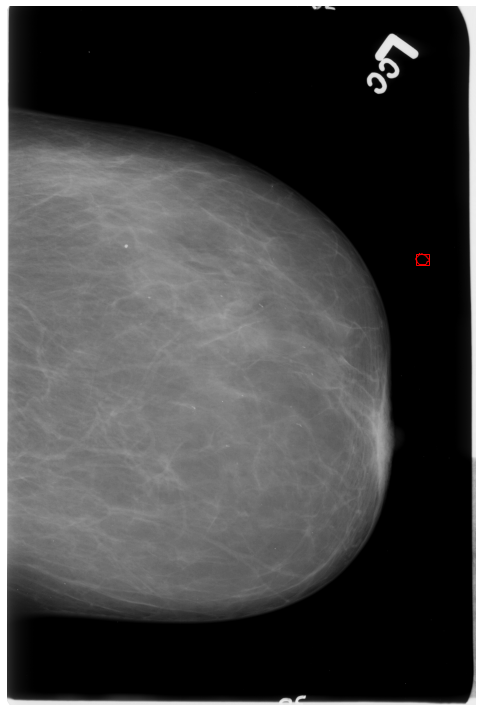

In [11]:

# Cargar el archivo COCO JSON
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

# Crear un diccionario de anotaciones por ID de imagen
annotations_by_image_id = {}
for annotation in coco_data['annotations']:
    image_id = annotation['image_id']
    if image_id not in annotations_by_image_id:
        annotations_by_image_id[image_id] = []
    annotations_by_image_id[image_id].append(annotation)

# Procesar las imágenes del COCO JSON
for image_info in coco_data['images']:
    image_id = image_info['id']
    dataset_id = image_info['Dataset_ID']
    file_name = image_info['file_name']
    annotations = annotations_by_image_id.get(image_id, [])
    
    # Rutas de entrada y salida
    input_image_path = os.path.join(input_dir, file_name)
    output_image_path = os.path.join(output_dir, file_name)
    
    dataset_id = re.search(r"P_\d+", input_image_path).group(0)
    # Crear subdirectorios en el directorio de salida si es necesario
    os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
    
    full_image_correspondent = find_full_path_for_roi(png_files, input_image_path, dataset_id)
    if full_image_correspondent == None:
        continue
#     print(full_image_correspondent)
#     print(input_image_path)
    
    # Cargar la imagen y trazar
    if os.path.exists(input_image_path):
        with Image.open(full_image_correspondent) as img:
            plot_image(img, annotations, save_path=output_image_path)

print("Generación de imágenes con segmentaciones completada.")

In [12]:
# Para split (con trodo el dataset)
import os
import re
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

# Directorio base de las imágenes PNG
png_dir = r"D:\Archivos_DICOM_PNG_DEF\manifest-ZkhPvrLo5216730872708713142\CBIS-DDSM"
png_files = glob.glob(os.path.join(png_dir, "**/*.png"), recursive=True)

# Cargar datos de los CSVs
csv_png_mass_test = pd.read_csv(r"D:\Archivos_DICOM_PNG_DEF\manifest-ZkhPvrLo5216730872708713142\nuevo_df_mass_test_png.csv")
csv_png_mass_train = pd.read_csv(r"D:\Archivos_DICOM_PNG_DEF\manifest-ZkhPvrLo5216730872708713142\nuevo_df_mass_train_png.csv")
csv_png_calc_test = pd.read_csv(r"D:\Archivos_DICOM_PNG_DEF\manifest-ZkhPvrLo5216730872708713142\nuevo_df_calc_test_png.csv")
csv_png_calc_train = pd.read_csv(r"D:\Archivos_DICOM_PNG_DEF\manifest-ZkhPvrLo5216730872708713142\nuevo_df_calc_train_png.csv")

# Crear un DataFrame temporal con las rutas y extraer patient_id de las rutas de los archivos
png_data = pd.DataFrame({
    "file_path": png_files,
    "patient_id": [re.search(r"P_\d+", path).group(0) for path in png_files]
})

# Unir todos los datasets de los CSVs en uno solo
all_data = pd.concat([
    csv_png_mass_test,
    csv_png_mass_train,
    csv_png_calc_test,
    csv_png_calc_train
], ignore_index=True)

# Combinar las rutas con los datos del CSV usando patient_id
all_data = all_data.merge(png_data, on="patient_id", how="left")

# Agrupar por paciente
grouped = all_data.groupby("patient_id").agg({
    "breast_density": "mean",  # Promedio de la densidad
    "file_path": list  # Lista de archivos por paciente
}).reset_index()

mode_density = grouped["breast_density"].mode()[0]
grouped["breast_density"].fillna(mode_density, inplace=True)

# Verificar la distribución de densidades
densities = grouped["breast_density"].value_counts(normalize=True).sort_index()
print("Distribución inicial de densidades:\n", densities)

# Dividir en conjuntos train, val, test
train, temp = train_test_split(grouped, test_size=0.4, stratify=grouped["breast_density"], random_state=42)
val, test = train_test_split(temp, test_size=0.5, stratify=temp["breast_density"], random_state=42)

# Validar la distribución de densidades en los conjuntos
print("Densidad Train:\n", train["breast_density"].value_counts().sort_index())
print("Densidad Val:\n", val["breast_density"].value_counts().sort_index())
print("Densidad Test:\n", test["breast_density"].value_counts().sort_index())

# Crear listas de archivos para cada conjunto, eliminando valores no válidos
train_files = train.explode("file_path")["file_path"].dropna().astype(str).tolist()
val_files = val.explode("file_path")["file_path"].dropna().astype(str).tolist()
test_files = test.explode("file_path")["file_path"].dropna().astype(str).tolist()

# Guardar los resultados en archivos
output_dir = r"D:\prueba_split_real"
os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(output_dir, "train_files.txt"), "w") as f:
    f.write("\n".join(train_files))

with open(os.path.join(output_dir, "val_files.txt"), "w") as f:
    f.write("\n".join(val_files))

with open(os.path.join(output_dir, "test_files.txt"), "w") as f:
    f.write("\n".join(test_files))

print(f"Archivos divididos y guardados en: {output_dir}")



Distribución inicial de densidades:
 1.0    0.095147
2.0    0.685185
3.0    0.160920
4.0    0.058748
Name: breast_density, dtype: float64
Densidad Train:
 1.0    0.094782
2.0    0.685836
3.0    0.160809
4.0    0.058573
Name: breast_density, dtype: float64
Densidad Val:
 1.0    0.095847
2.0    0.683706
3.0    0.159744
4.0    0.060703
Name: breast_density, dtype: float64
Densidad Test:
 1.0    0.095541
2.0    0.684713
3.0    0.162420
4.0    0.057325
Name: breast_density, dtype: float64
Archivos divididos y guardados en: D:\prueba_split_real


In [5]:
import os
import re
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

# Directorio base de las imágenes PNG
png_dir = r"D:\Archivos_DICOM_PNG_DEF\manifest-ZkhPvrLo5216730872708713142\CBIS-DDSM"
png_files = [f for f in glob.glob(os.path.join(png_dir, "**/*.png"), recursive=True) if "test" not in f]

# Cargar datos de los CSVs
csv_png_mass_train = pd.read_csv(r"D:\Archivos_DICOM_PNG_DEF\manifest-ZkhPvrLo5216730872708713142\nuevo_df_mass_train_png.csv")
csv_png_calc_train = pd.read_csv(r"D:\Archivos_DICOM_PNG_DEF\manifest-ZkhPvrLo5216730872708713142\nuevo_df_calc_train_png.csv")

# Crear un DataFrame temporal con las rutas y extraer patient_id de las rutas de los archivos
png_data = pd.DataFrame({
    "file_path": png_files,
    "patient_id": [re.search(r"P_\d+", path).group(0) for path in png_files]
})

# Unir todos los datasets de los CSVs en uno solo
all_data = pd.concat([
    csv_png_mass_train,
    csv_png_calc_train
], ignore_index=True)

# Combinar las rutas con los datos del CSV usando patient_id
all_data = all_data.merge(png_data, on="patient_id", how="left")

# Agrupar por paciente
grouped = all_data.groupby("patient_id").agg({
    "breast_density": "mean",  # Promedio de la densidad
    "file_path": list  # Lista de archivos por paciente
}).reset_index()

# Rellenar valores faltantes de densidad con la moda
mode_density = grouped["breast_density"].mode()[0]
grouped["breast_density"].fillna(mode_density, inplace=True)

# Verificar la distribución de densidades
densities = grouped["breast_density"].value_counts(normalize=True).sort_index()
print("Distribución inicial de densidades:\n", densities)

# Dividir en conjuntos train y val
train, val = train_test_split(grouped, test_size=0.4, stratify=grouped["breast_density"], random_state=42)

# Validar la distribución de densidades en los conjuntos
print("Densidad Train:\n", train["breast_density"].value_counts().sort_index())
print("Densidad Val:\n", val["breast_density"].value_counts().sort_index())

# Crear listas de archivos para cada conjunto, eliminando valores no válidos
train_files = train.explode("file_path")["file_path"].dropna().astype(str).tolist()
val_files = val.explode("file_path")["file_path"].dropna().astype(str).tolist()

# Guardar los resultados en archivos
output_dir = r"D:\prueba_split_real_soloTrain_notest"
os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(output_dir, "train_files.txt"), "w") as f:
    f.write("\n".join(train_files))

with open(os.path.join(output_dir, "val_files.txt"), "w") as f:
    f.write("\n".join(val_files))

print(f"Archivos divididos y guardados en: {output_dir}")

Distribución inicial de densidades:
 1.0    0.099359
2.0    0.691506
3.0    0.155449
4.0    0.053686
Name: breast_density, dtype: float64
Densidad Train:
 1.0     75
2.0    517
3.0    116
4.0     40
Name: breast_density, dtype: int64
Densidad Val:
 1.0     49
2.0    346
3.0     78
4.0     27
Name: breast_density, dtype: int64
Archivos divididos y guardados en: D:\prueba_split_real_soloTrain_notest


In [11]:
for i in png_files:
    if "test" in i:
        print(i)

- Crear Train/Split a partir de los de train
- Empezar con mmdetection
- Estadisticas